<a href="https://colab.research.google.com/github/AndreHucke/gen_ai/blob/main/VAE/waveform_manipulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

Start by mounting the Google Drive directory. I decided to do this so I don't have to manually upload the waveform file every time I start a new runtime, which saves a lot of time. Then, I cd into the specific project directory and print the path to the screen just as a sanity check to ensure I am working in the correct location.

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/PhD/Generative_AI_for_Engineers/
! pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/PhD/Generative_AI_for_Engineers
/content/drive/MyDrive/PhD/Generative_AI_for_Engineers


---

Load the dataset and inspect its dimensions. I chose pandas to read the CSV since the data is tabular and it is the tool I am most comfortable with for this task. I then print the dataframe shape to verify the amount of samples and features (2000 samples and 130 columns, which includes the labels and label names in the last two positions). I also perform a sanity check on my dataframe, looking for any NA values to ensure the data is clean, and finally look at the head of the dataframe to confirm everything loaded correctly.

---

In [2]:
import pandas as pd

df = pd.read_csv('waveforms_two_class.csv')
print(f'Samples by features: {df.shape}')
print(f'Column names: {df.columns}')
print(f'NA check: {df.isna().sum().sum()}')
print(f'\nHead')
df.head()

Samples by features: (2000, 130)
Column names: Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       ...
       'x120', 'x121', 'x122', 'x123', 'x124', 'x125', 'x126', 'x127', 'label',
       'label_name'],
      dtype='object', length=130)
NA check: 0

Head


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x120,x121,x122,x123,x124,x125,x126,x127,label,label_name
0,-0.947141,-0.838508,-0.897306,-0.891606,-0.882936,-0.873445,-0.956327,-0.889972,-0.888553,-0.932892,...,-0.941790,-0.885358,-0.840000,-0.869320,-0.986899,-0.855718,-0.925747,-0.887413,1,square
1,0.786143,0.944359,0.909509,0.828856,0.768542,0.692954,0.534794,0.414327,0.190835,-0.153061,...,-0.754151,-0.762131,-0.936944,-0.922856,-0.808356,-0.725042,-0.625543,-0.509568,0,sine
2,-0.911261,0.920661,0.791735,0.892718,0.911063,0.878976,0.900652,0.877653,0.870198,0.870511,...,0.878529,0.870021,0.898435,-0.869937,-1.000000,-0.774808,-0.915988,-0.849216,1,square
3,-0.783615,-0.900473,-0.925583,-0.989462,-0.745357,-0.693783,-0.444357,-0.271567,0.040077,0.280479,...,-0.113384,0.166106,0.416596,0.653322,0.719588,0.920724,1.000000,0.989300,0,sine
4,0.851972,0.885557,0.913848,0.862640,0.888450,-0.884866,-0.975754,-0.863823,-0.944364,-0.844752,...,-0.910218,-0.956567,-1.000000,-0.894092,-0.883763,-0.930647,0.899971,0.941150,1,square


---

Let's play around with some plots using Seaborn. Since I am most familiar with Matplotlib, I wanted to try something new, though I realized it is built on top of Matplotlib, so I still need to use the underlying library. However, Seaborn is still cool for fast statistical visualization. I decided to randomly select a waveform from the dataset, dropping the label and label_name features to plot the raw signal as a line, and then adding the expected waveform type (from the label_name) to the title for verification.

---

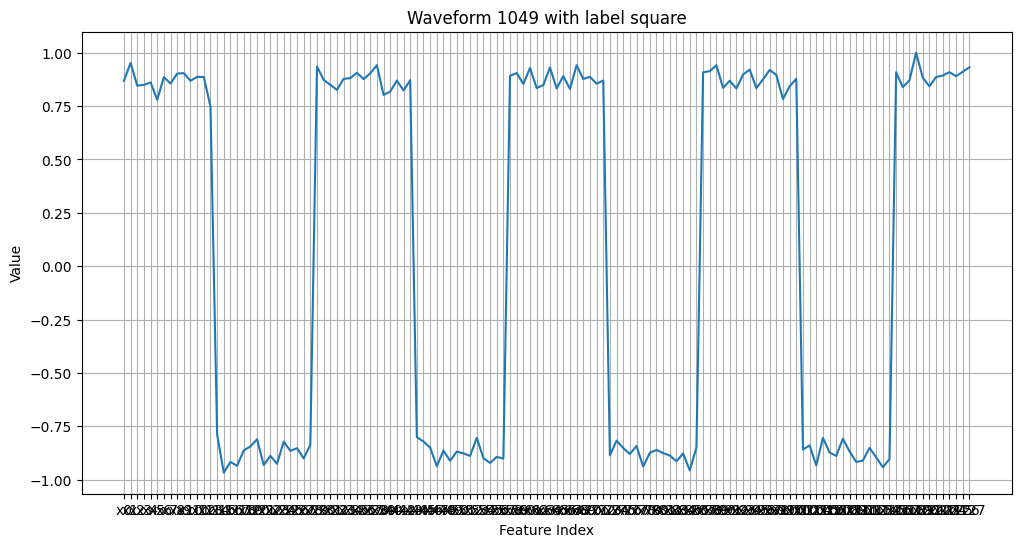

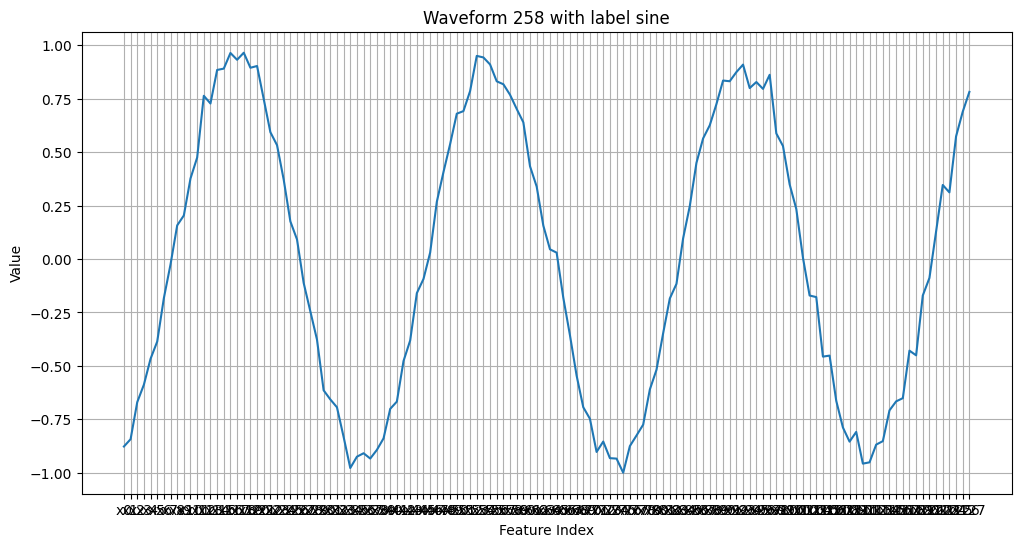

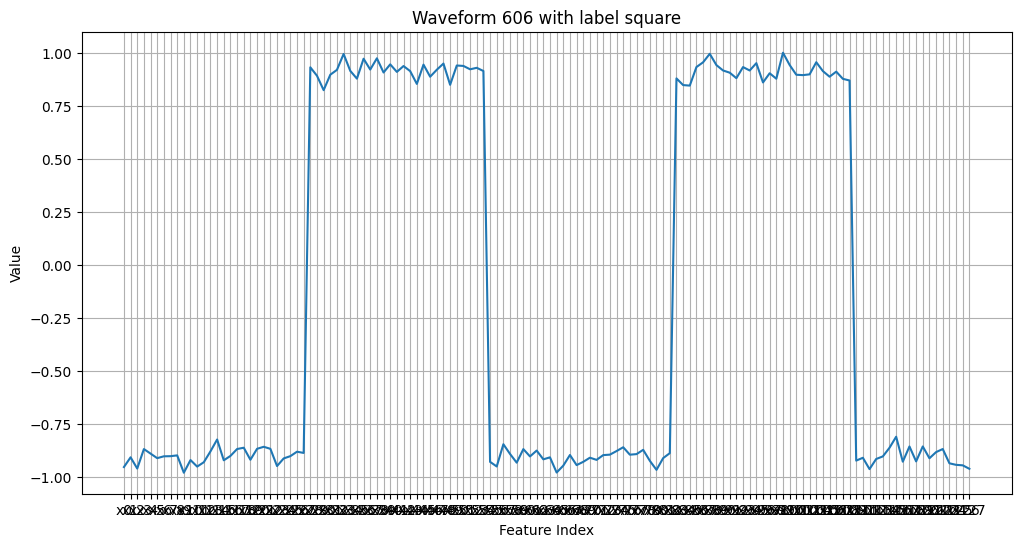

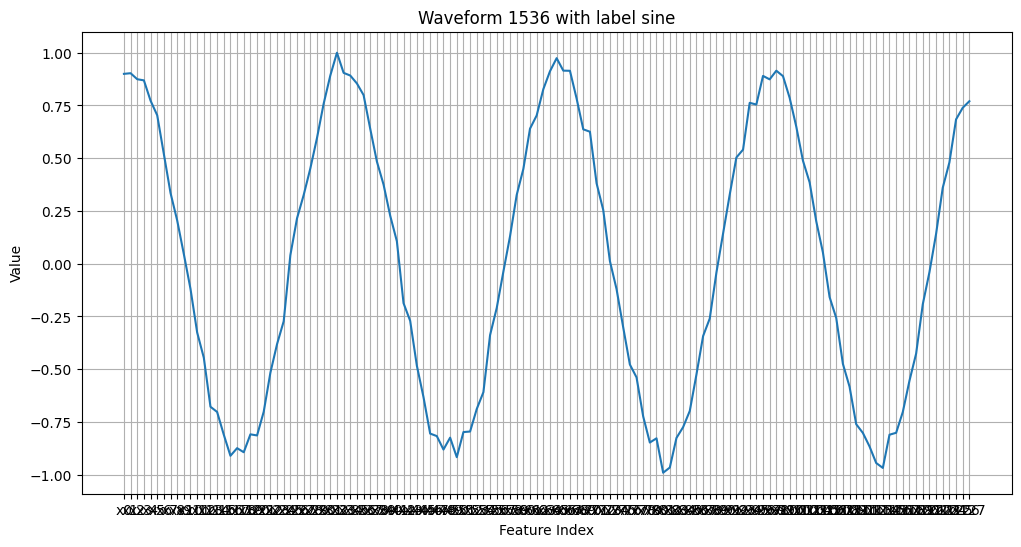

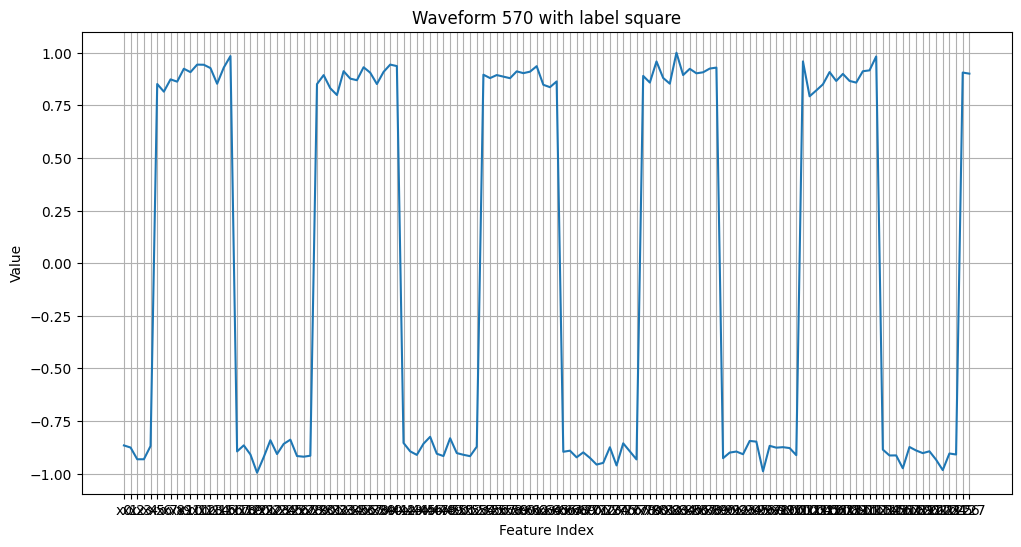

In [3]:
from numpy.random import randint
import seaborn
import matplotlib.pyplot as plt

for i in range(5):
  n = randint(0, len(df))

  row_numeric = df.iloc[n].drop(['label', 'label_name'])

  label_str = df.iloc[n]['label_name']

  plt.figure(figsize=(12, 6))
  seaborn.lineplot(x=row_numeric.index, y=row_numeric.values)
  plt.title(f'Waveform {n} with label {label_str}')
  plt.xlabel('Feature Index')
  plt.ylabel('Value')
  plt.grid(True)
  plt.show()

---

Load the torch libraries for the model creation.

I create the train, val, and test splits with random splitting and class balance. I used the stratify parameter here because I don't want to train only on sine waves, for instance; I need the model to see a representative distribution of all waveforms.

I also decided to scale the data between -1 and 1 using MinMaxScaler. This choice was made to match the Tanh activation function I plan to use in the decoder's output. I fit the scaler only on the training set to prevent data leakage into the validation or test sets.

Finally, I wrap everything into DataLoaders to create the batches for each training step.

---

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Prepare Features and Labels
# We need 'y' (labels) specifically for the stratify parameter,
# even though the VAE only trains on 'X'.
X = df.drop(['label', 'label_name'], axis=1).values
y = df['label'].values

# First Split: Separate Train (80%) from Temp (20%)
# stratify=y ensures class balance is maintained in both sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Second Split: Separate Temp into Validation (10%) and Test (10%)
# We split the 20% chunk in half (0.5) to get two equal 10% chunks
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Initialize Scaler to fit between -1 and 1 (matching Tanh)
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit on Train ONLY to prevent data leakage, then transform all
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Create TensorDatasets
# We strictly convert only the features (X) to tensors for the VAE
train_dataset = TensorDataset(torch.FloatTensor(X_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test))

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verification
print(f"Total samples: {len(df)}")
print(f"Train samples: {len(train_dataset)} ({len(train_dataset)/len(df):.0%})")
print(f"Val samples:   {len(val_dataset)} ({len(val_dataset)/len(df):.0%})")
print(f"Test samples:  {len(test_dataset)} ({len(test_dataset)/len(df):.0%})")

Total samples: 2000
Train samples: 1600 (80%)
Val samples:   200 (10%)
Test samples:  200 (10%)


---

Creating the VAE with torch. Since it is a VAE, I defined an encoder block to compress the data into a latent space and a decoder block that attempts to reconstruct the data based solely on that latent representation.

The reparameterize block is included to enable the "reparameterization trick" I learned about on Gemini, allowing gradients to flow back through the stochastic sampling step during training.

For my first pass, I decided to use a ReLU activation function, which in hindsight was not the best decision. Because I standardized the inputs to range from -1 to 1, a standard ReLU would zero out all the negative values, effectively discarding half the "shape" information of the waveforms. So, I decided to use Leaky ReLU in the forward block. This choice allows me to retain the benefits of ReLU while preserving the negative values that I considered important for this specific dataset.

---

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=64, latent_dim=8):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim) # Mean (mu)
        self.fc22 = nn.Linear(hidden_dim, latent_dim) # Log variance (logvar)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        h1 = F.leaky_relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)

        # Reparameterize
        z = self.reparameterize(mu, logvar)

        # Decode
        h3 = F.leaky_relu(self.fc3(z))
        recon_x = torch.tanh(self.fc4(h3)) # Using Tanh since data is normalized in [-1, 1]

        return recon_x, mu, logvar

---

I decided to run a quick test to find the best hyperparameters because I was curious to see what kind of behavior different settings would show on small, quick tests.

First, I define the loss function based on the standard VAE objective: combining Mean Squared Error (MSE) to measure reconstruction accuracy and Kullback-Leibler Divergence (KLD) to regularize the latent space distributions.

Then I start my trial runs, setting a small number of epochs for speed and a short patience window for early stopping. I iterate through the epochs and batches and then validate. This setup allows me to quickly discard poor configurations without wasting compute time.

The random search starts on the next loop and selects the appropriate parameters based on their type (integers for dimensions, floats for learning rate). Finally, I use a few print statements to monitor the training progress and save the best model hyperparameters at the end.

---

In [6]:
import random
import math
import torch.optim as optim
import torch

# Define the Search Space
# We define lists of potential values for each hyperparameter
param_grid = {
    'latent_dim': (4, 64, 'int'),
    'hidden_dim': (16, 256, 'int'),
    'lr': (1e-4, 1e-1, 'log-uniform')
}

# Define Loss Function
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Wrapper Function for Training
def train_trial(config, trial_id):
    """
    Trains a model with specific hyperparameters for a limited number of epochs
    to determine viability. Returns the best validation loss achieved.
    """
    # Instantiate model with dynamic config
    model = VAE(
        input_dim=128,
        hidden_dim=config['hidden_dim'],
        latent_dim=config['latent_dim']
    )

    optimizer = optim.Adam(model.parameters(), lr=config['lr'])

    # Search settings (faster than full training)
    epochs = 30          # Fewer epochs for search to save time
    patience = 5         # Aggressive early stopping
    best_loss = float('inf')
    counter = 0

    print(f"\n--- Trial {trial_id} | Config: {config} ---")

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            data = batch[0]
            optimizer.zero_grad()
            recon, mu, logvar = model(data)
            loss = loss_function(recon, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                data = batch[0]
                recon, mu, logvar = model(data)
                loss = loss_function(recon, data, mu, logvar)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader.dataset)

        # Check for improvement
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f"   Early stopping at epoch {epoch+1}")
            break

    print(f"   Best Val Loss: {best_loss:.4f}")
    return best_loss

# Execution Loop
num_trials = 50
results = []

print(f"Starting Random Search for {num_trials} trials...")

for i in range(num_trials):
    config = {}

    for key, val in param_grid.items():
        if isinstance(val, tuple):
            low, high, dist_type = val

            if dist_type == 'int':
                # Pick a random integer between low and high
                config[key] = random.randint(low, high)

            elif dist_type == 'log-uniform':
                # Pick a random float on a logarithmic scale
                log_low = math.log10(low)
                log_high = math.log10(high)
                config[key] = 10 ** random.uniform(log_low, log_high)

    # Force integer types for dimensions (crucial for PyTorch)
    config['hidden_dim'] = int(config['hidden_dim'])
    config['latent_dim'] = int(config['latent_dim'])

    # Run trial
    # We use a try/except block to catch bad combos (like negative dimensions) just in case
    try:
        final_loss = train_trial(config, i+1)
        results.append((config, final_loss))
    except Exception as e:
        print(f"Trial {i+1} failed with error: {e}")
        results.append((config, float('inf')))

# Analyze Results
results.sort(key=lambda x: x[1])

print("\n" + "="*40)
print("TOP 3 CONFIGURATIONS")
print("="*40)
for rank, (cfg, loss) in enumerate(results[:3]):
    print(f"{rank+1}. Loss: {loss:.4f} | {cfg}")

if results:
    best_config = results[0][0]
    print(f"\nWinner: {best_config}")

    # Re-instantiate the best model for the final full training run
    model = VAE(
        input_dim=128,
        hidden_dim=best_config['hidden_dim'],
        latent_dim=best_config['latent_dim']
    )
    optimizer = optim.Adam(model.parameters(), lr=best_config['lr'])
    print("\nModel reset with winning hyperparameters. Ready for full training.")

Starting Random Search for 50 trials...

--- Trial 1 | Config: {'latent_dim': 22, 'hidden_dim': 29, 'lr': 0.0002357056027694898} ---
   Best Val Loss: 46.4533

--- Trial 2 | Config: {'latent_dim': 22, 'hidden_dim': 131, 'lr': 0.046289305409835314} ---
   Early stopping at epoch 21
   Best Val Loss: 42.8955

--- Trial 3 | Config: {'latent_dim': 34, 'hidden_dim': 193, 'lr': 0.001092375159182636} ---
   Best Val Loss: 25.8072

--- Trial 4 | Config: {'latent_dim': 23, 'hidden_dim': 117, 'lr': 0.0008094915904232844} ---
   Best Val Loss: 27.0723

--- Trial 5 | Config: {'latent_dim': 20, 'hidden_dim': 65, 'lr': 0.0005730329556810517} ---
   Best Val Loss: 29.8709

--- Trial 6 | Config: {'latent_dim': 6, 'hidden_dim': 64, 'lr': 0.0017086978981793817} ---
   Best Val Loss: 23.3865

--- Trial 7 | Config: {'latent_dim': 12, 'hidden_dim': 202, 'lr': 0.00021192144418959633} ---
   Best Val Loss: 26.9562

--- Trial 8 | Config: {'latent_dim': 64, 'hidden_dim': 113, 'lr': 0.016669361339026346} ---
  

---
Now, I am running the full model training using the winner. This is very similar to the trial runs, but with more epochs and patience for a longer training session. I also decided to train two additional models with 2x and 3x the latent dimension of the winner to answer the grad student question.

I also captured the loss history during this loop so I can plot the curves side-by-side later.

---

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torch.optim as optim

# Define the 3 configurations: winner, 2x latent, 3x latent
configs = [
    {
        'name': f"Winner (latent={best_config['latent_dim']})",
        'hidden_dim': best_config['hidden_dim'],
        'latent_dim': best_config['latent_dim'],
        'lr': best_config['lr']
    },
    {
        'name': f"2x Latent (latent={best_config['latent_dim'] * 2})",
        'hidden_dim': best_config['hidden_dim'],
        'latent_dim': best_config['latent_dim'] * 2,
        'lr': best_config['lr']
    },
    {
        'name': f"3x Latent (latent={best_config['latent_dim'] * 3})",
        'hidden_dim': best_config['hidden_dim'],
        'latent_dim': best_config['latent_dim'] * 3,
        'lr': best_config['lr']
    }
]

print("Training 3 models with different latent dimensions:")
for cfg in configs:
    print(f"  - {cfg['name']}: hidden_dim={cfg['hidden_dim']}, lr={cfg['lr']:.6f}")

# Store trained models
trained_models = []

# Training function for a single model
def train_full_model(config, model_idx):
    """Train a model with given config and return the trained model."""
    print(f"\n{'='*50}")
    print(f"Training Model {model_idx + 1}: {config['name']}")
    print(f"{'='*50}")

    model = VAE(
        input_dim=128,
        hidden_dim=config['hidden_dim'],
        latent_dim=config['latent_dim']
    )
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])

    # Early Stopping parameters
    max_epochs = 200
    patience = 15
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []
    best_state = None

    for epoch in range(max_epochs):
        # Train Step
        model.train()
        train_loss = 0
        for batch in train_loader:
            data = batch[0]
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation Step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                data = batch[0]
                recon_batch, mu, logvar = model(data)
                loss = loss_function(recon_batch, data, mu, logvar)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        # Print progress every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f'  Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

        # Early Stopping Check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'  Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}')
                break

    # Load best state
    if best_state is not None:
        model.load_state_dict(best_state)

    print(f"  Final Best Val Loss: {best_val_loss:.4f}")
    return model, train_losses, val_losses

# Train all 3 models
for idx, cfg in enumerate(configs):
    model, train_losses, val_losses = train_full_model(cfg, idx)
    trained_models.append({
        'model': model,
        'config': cfg,
        'train_losses': train_losses,
        'val_losses': val_losses
    })

print("\n" + "="*50)
print("All 3 models trained successfully!")
print("="*50)

Training 3 models with different latent dimensions:
  - Winner (latent=9): hidden_dim=164, lr=0.006034
  - 2x Latent (latent=18): hidden_dim=164, lr=0.006034
  - 3x Latent (latent=27): hidden_dim=164, lr=0.006034

Training Model 1: Winner (latent=9)
  Epoch 20 | Train Loss: 21.7600 | Val Loss: 22.4034
  Epoch 40 | Train Loss: 20.4694 | Val Loss: 21.7051
  Epoch 60 | Train Loss: 19.5456 | Val Loss: 20.6230
  Epoch 80 | Train Loss: 19.1774 | Val Loss: 20.5139
  Epoch 100 | Train Loss: 18.8205 | Val Loss: 20.3535
  Epoch 120 | Train Loss: 18.7686 | Val Loss: 19.7941
  Early stopping at epoch 128. Best Val Loss: 19.3906
  Final Best Val Loss: 19.3906

Training Model 2: 2x Latent (latent=18)
  Epoch 20 | Train Loss: 22.5955 | Val Loss: 22.7191
  Epoch 40 | Train Loss: 20.8652 | Val Loss: 21.4130
  Epoch 60 | Train Loss: 19.7877 | Val Loss: 20.6867
  Early stopping at epoch 64. Best Val Loss: 20.2572
  Final Best Val Loss: 20.2572

Training Model 3: 3x Latent (latent=27)
  Epoch 20 | Train L

---
I plotted the validation loss curves to verify that they followed the classic exponential decay shape, and indeed, all models showed a healthy convergence.

Interestingly, the "Winner" model (blue line, latent=9) achieved the lowest final validation loss and trained for the longest duration. The largest model (red) plateaued earlier at a higher loss, as expected. However, the middle-ground model (green, latent=18) is the most intriguing: it stopped the earliest of all. This raises an important question: Does this early stop indicate it got "stuck," or did it find a stable solution faster than the others? We shouldn't assume the lowest loss automatically equals the best visual quality, so this discrepancy is something we will specifically look for in the subsequent generation plots.

---

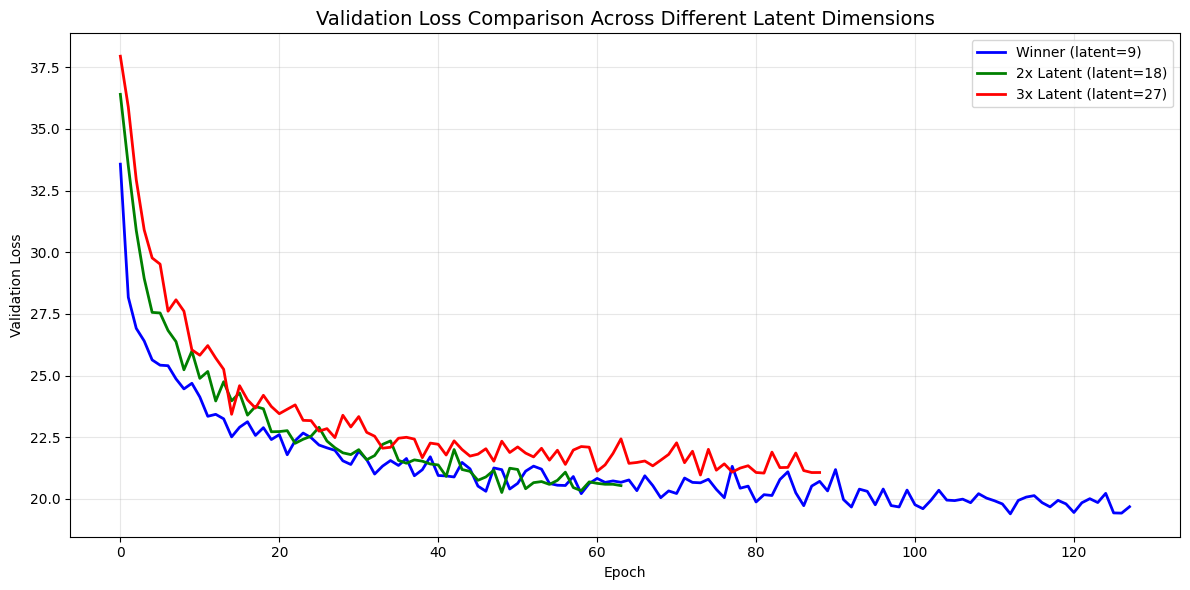


All comparison plots generated successfully!


In [12]:
# Summary of the loss curves
fig, ax = plt.subplots(figsize=(12, 6))

colors_models = ['blue', 'green', 'red']
for idx, item in enumerate(trained_models):
    ax.plot(item['val_losses'], label=f"{item['config']['name']}", color=colors_models[idx], linewidth=2)

ax.set_title('Validation Loss Comparison Across Different Latent Dimensions', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Loss')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("All comparison plots generated successfully!")
print("="*50)

---

Here we are trying to see if the model has clusters using UMAP. I chose UMAP because I wanted to see if my data clustered together, and UMAP is good at preserving structure in the data.

I extract the latent representations (mu) from the test set for all three models and project them down to 2 dimensions. By color-coding the points with their true labels, I was hoping to see "Sine" and "Square" classes separated into distinct clusters.

However, as the plots show, I didn't get distinct clusters. Instead, I got continuous, "string-like" manifolds where the classes are interleaved. I am guessing that this makes sense because I didn't feed the labels to the model during training; the VAE organized the data based on continuous features (likely phase or frequency) rather than discrete categories. According to Gemini, this continuous structure is actually a good sign for generative tasks, as it suggests the latent space is smooth and allows for transitions between shapes, even if it doesn't separate the classes perfectly.

---

Generating UMAP projections for all 3 models...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  - Winner (latent=9): UMAP complete


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  - 2x Latent (latent=18): UMAP complete


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  - 3x Latent (latent=27): UMAP complete


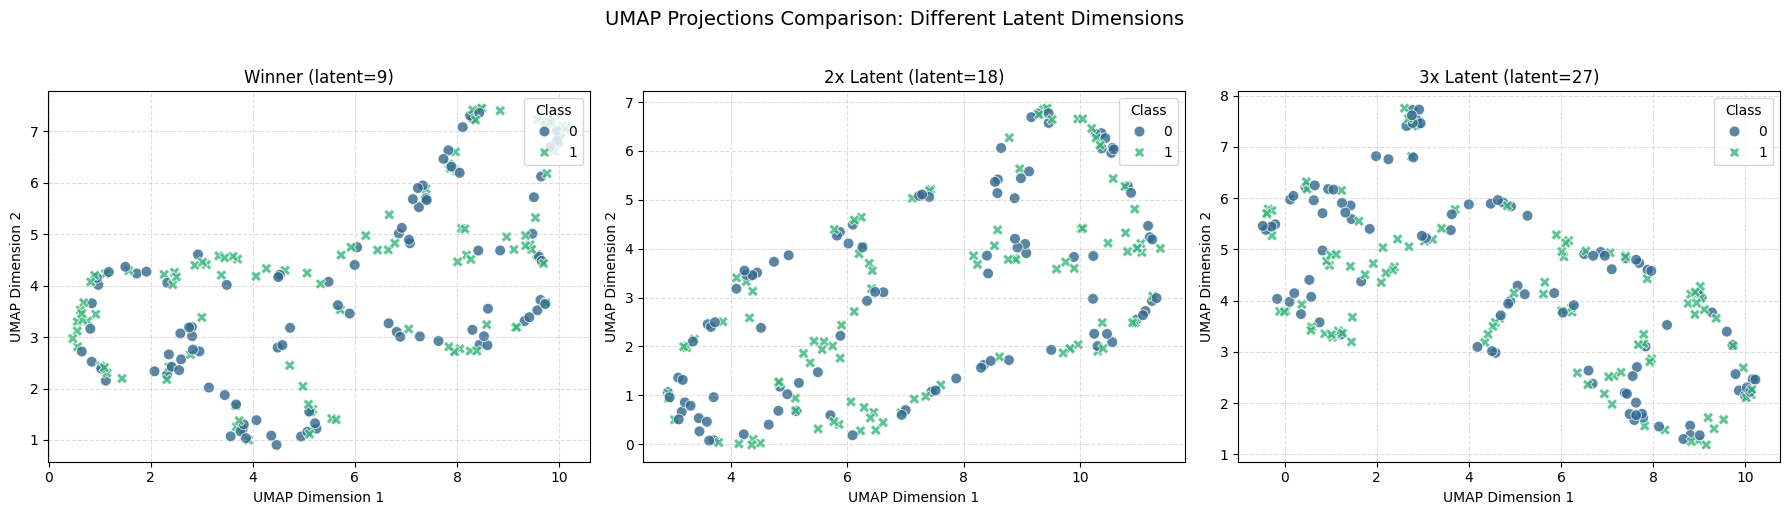

In [8]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np

# Get the full test tensor
full_test_tensor = test_dataset.tensors[0]

# Store UMAP results for each model
umap_results = []

print("Generating UMAP projections for all 3 models...")

for item in trained_models:
    model = item['model']
    config = item['config']

    model.eval()
    with torch.no_grad():
        _, mu, _ = model(full_test_tensor)
        latent_space = mu.numpy()

    # Apply UMAP
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    latent_2d = reducer.fit_transform(latent_space)

    umap_results.append({
        'latent_2d': latent_2d,
        'reducer': reducer,
        'config': config
    })
    print(f"  - {config['name']}: UMAP complete")

# Plot UMAP side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, result in enumerate(umap_results):
    ax = axes[idx]
    sns.scatterplot(
        x=result['latent_2d'][:, 0],
        y=result['latent_2d'][:, 1],
        hue=y_test,
        palette='viridis',
        style=y_test,
        s=60,
        alpha=0.8,
        ax=ax
    )
    ax.set_title(result['config']['name'], fontsize=12)
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(title='Class', loc='upper right')

plt.suptitle('UMAP Projections Comparison: Different Latent Dimensions', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---

Let's see some generated curves.

First, I identify specific reference samples ("anchors") from the test set—one Sine and one Square. I did this to test the generative stability of the latent space. By adding random Gaussian noise to the latent vector of these anchors and decoding the result, I can verify if the model produces coherent variations of the original shape.

The results confirm the stability of the model. As shown in the plots, the generated variations (dashed lines) closely track the original anchor (black line) without degenerating into random noise. However, the square shape was apparently easier for the model to recreate, with the sine wave appearing a lot more "noisy" in comparison.

Comparing the three latent sizes (left to right), I noticed that the "Winner" model (latent=9) produces variations that have a significant amount of jitter when compared to the second model (latent=18), and is actually closer in performance to the largest latent space (latent=27). This indicates that the "best" model was not perfectly selected, showing the "curse of grad student optimization." Most likely, the ideal latent space size for this specific hidden dimension (hidden_dim=164) and learning rate (lr=0.006034) was closer to 18, but the random search settled on 9 since I didn't look at all possibilities. Still, all models were rather successful with the square wave, and when we consider the previous plots, they show strong signs of overall robustness.

---

Generating variations for all 3 models...
  - Winner (latent=9): Variations generated
  - 2x Latent (latent=18): Variations generated
  - 3x Latent (latent=27): Variations generated


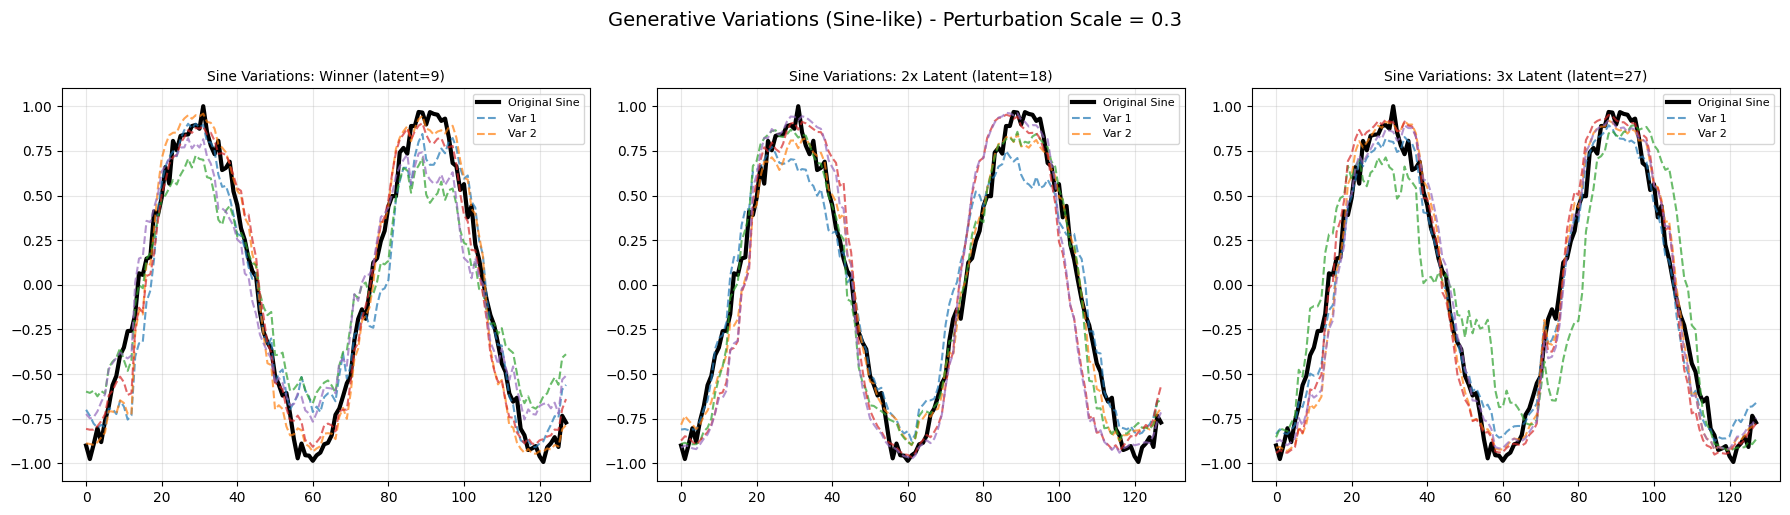

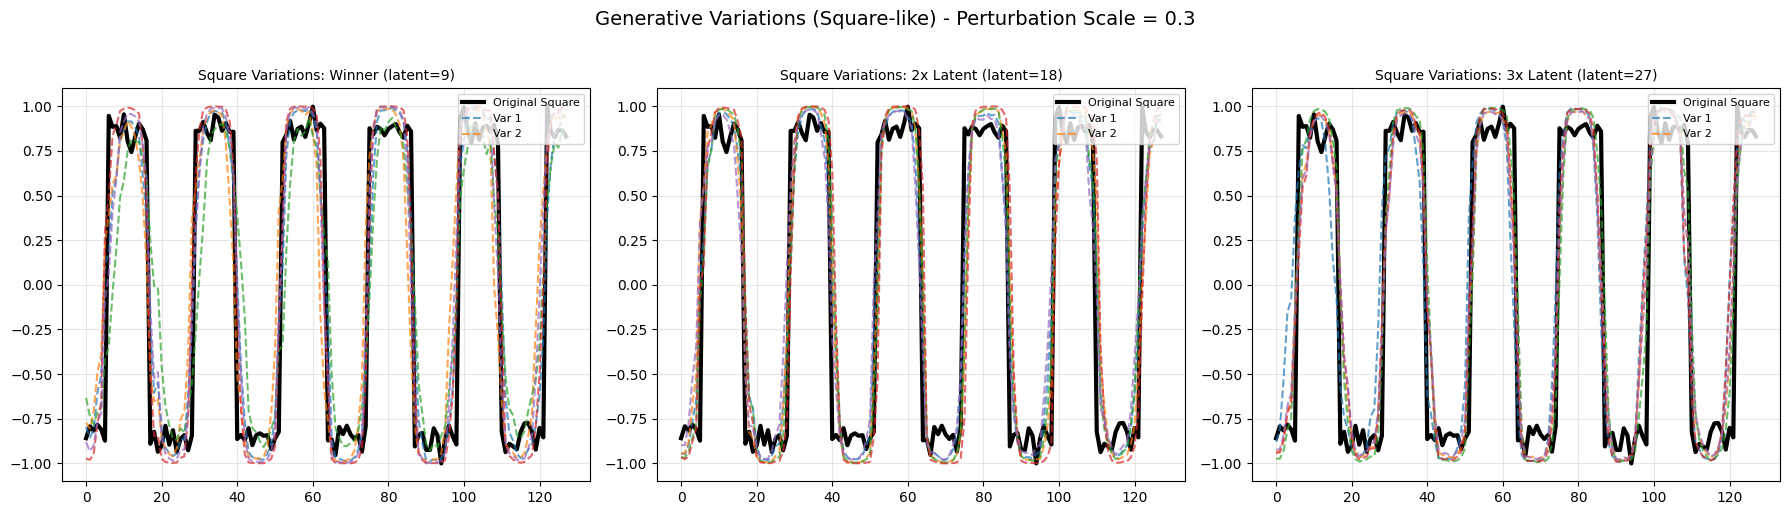

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Settings
perturbation_scale = 0.3
num_variations = 5

# Find Reference Samples ("Anchors") in the Test Set
idx_sine = np.where(y_test == 0)[0][0]
idx_square = np.where(y_test == 1)[0][0]

# Get the actual tensors for these anchors
anchor_sine = test_dataset[idx_sine][0].unsqueeze(0)
anchor_square = test_dataset[idx_square][0].unsqueeze(0)

# Store generated variations for each model
all_generated = []

print("Generating variations for all 3 models...")

for item in trained_models:
    model = item['model']
    config = item['config']

    model.eval()
    with torch.no_grad():
        _, mu_sine, _ = model(anchor_sine)
        _, mu_square, _ = model(anchor_square)

    generated_sines = []
    generated_squares = []

    with torch.no_grad():
        for _ in range(num_variations):
            noise = torch.randn_like(mu_sine) * perturbation_scale
            z_sine_new = mu_sine + noise
            z_square_new = mu_square + noise

            recon_sine = torch.tanh(model.fc4(F.leaky_relu(model.fc3(z_sine_new))))
            recon_square = torch.tanh(model.fc4(F.leaky_relu(model.fc3(z_square_new))))

            generated_sines.append(recon_sine.squeeze().numpy())
            generated_squares.append(recon_square.squeeze().numpy())

    all_generated.append({
        'sines': generated_sines,
        'squares': generated_squares,
        'config': config
    })
    print(f"  - {config['name']}: Variations generated")

# Plot Sine variations side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, gen in enumerate(all_generated):
    ax = axes[idx]
    ax.plot(anchor_sine.squeeze().numpy(), color='black', linewidth=3, label='Original Sine')
    for i, wave in enumerate(gen['sines']):
        ax.plot(wave, alpha=0.7, linestyle='--', label=f'Var {i+1}' if i < 2 else None)
    ax.set_title(f"Sine Variations: {gen['config']['name']}", fontsize=10)
    ax.set_ylim(-1.1, 1.1)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)

plt.suptitle(f'Generative Variations (Sine-like) - Perturbation Scale = {perturbation_scale}', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Plot Square variations side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, gen in enumerate(all_generated):
    ax = axes[idx]
    ax.plot(anchor_square.squeeze().numpy(), color='black', linewidth=3, label='Original Square')
    for i, wave in enumerate(gen['squares']):
        ax.plot(wave, alpha=0.7, linestyle='--', label=f'Var {i+1}' if i < 2 else None)
    ax.set_title(f"Square Variations: {gen['config']['name']}", fontsize=10)
    ax.set_ylim(-1.1, 1.1)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)

plt.suptitle(f'Generative Variations (Square-like) - Perturbation Scale = {perturbation_scale}', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


---

As for the transition between one class to the other, this was the first visualization approach I tried. It demonstrates how we can linearly interpolate between two points in the latent space. I chose a start point (Class 0) and an end point (Class 1) and generated 25 intermediate steps. By decoding these intermediate latent vectors, I can visualize the "morphing" process.

This reinforces the idea of latent space as continuous presented by Gemini. If it is, I should see a smooth transformation from a sine wave to a square wave, rather than a sudden jump or garbage output in the middle. Looking at the results, the transition is smooth across all models. We can clearly see the rounded peaks of the sine wave gradually flattening out and sharpening into the plateaus of the square wave. This confirms that the model has learned a continuous manifold where "shape" is a fluid property that can be manipulated mathematically.

One thing I did not do was starting from 1 to 0, that I can further investigate.

---

Generating interpolations for all 3 models...
  - Winner (latent=9): Interpolation complete
  - 2x Latent (latent=18): Interpolation complete
  - 3x Latent (latent=27): Interpolation complete


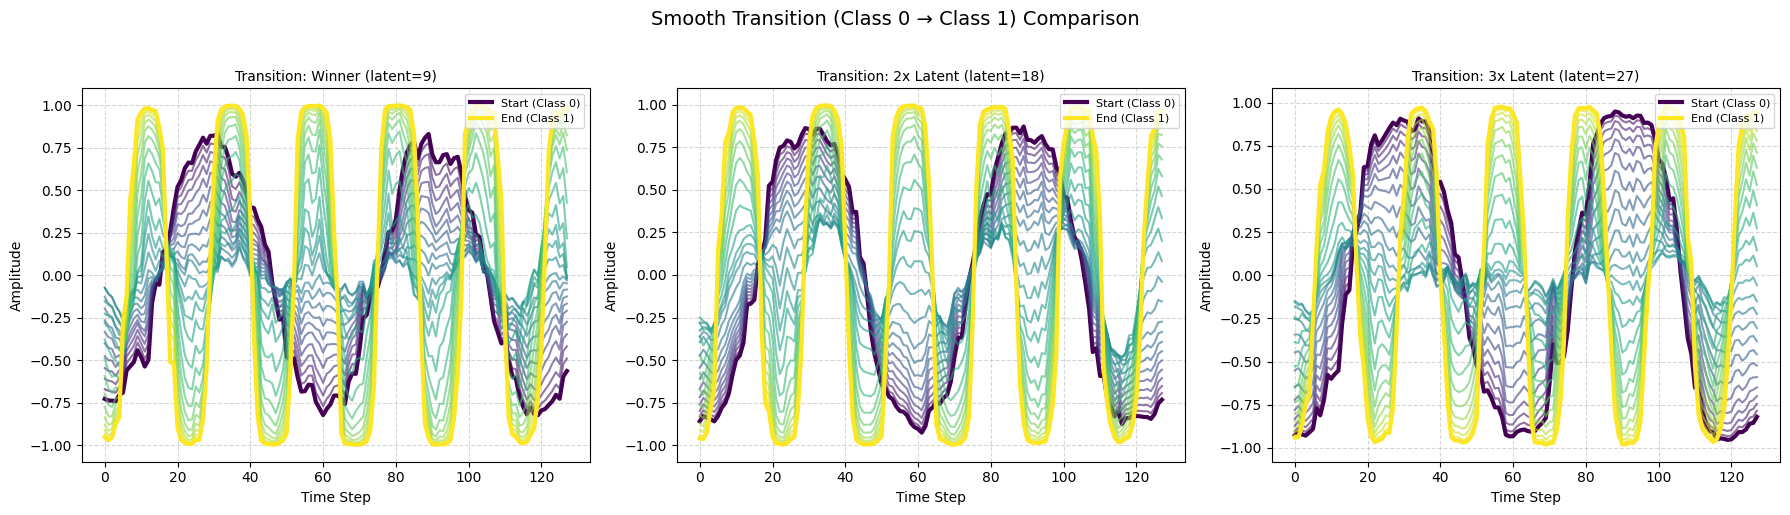

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Select Start (Class 0) and End (Class 1) samples
idx0 = np.where(y_test == 0)[0][0]
idx1 = np.where(y_test == 1)[0][0]

wave0 = test_dataset[idx0][0].unsqueeze(0)
wave1 = test_dataset[idx1][0].unsqueeze(0)

steps = 25
alphas = torch.linspace(0, 1, steps)

# Store interpolated waveforms for each model
all_interpolations = []

print("Generating interpolations for all 3 models...")

for item in trained_models:
    model = item['model']
    config = item['config']

    model.eval()
    with torch.no_grad():
        _, mu0, _ = model(wave0)
        _, mu1, _ = model(wave1)

    interpolated_waveforms = []
    with torch.no_grad():
        for alpha in alphas:
            z_interp = (1 - alpha) * mu0 + alpha * mu1
            h3 = F.leaky_relu(model.fc3(z_interp))
            recon_interp = torch.tanh(model.fc4(h3))
            interpolated_waveforms.append(recon_interp.squeeze().numpy())

    all_interpolations.append({
        'waves': interpolated_waveforms,
        'mu0': mu0,
        'mu1': mu1,
        'config': config
    })
    print(f"  - {config['name']}: Interpolation complete")

# Plot Waveform Transitions side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = plt.cm.viridis(np.linspace(0, 1, steps))

for idx, interp in enumerate(all_interpolations):
    ax = axes[idx]
    for i, wave in enumerate(interp['waves']):
        if i == 0:
            label = "Start (Class 0)"
            lw = 3
            alpha_val = 1.0
        elif i == steps - 1:
            label = "End (Class 1)"
            lw = 3
            alpha_val = 1.0
        else:
            label = None
            lw = 1.5
            alpha_val = 0.6
        ax.plot(wave, color=colors[i], linewidth=lw, alpha=alpha_val, label=label)

    ax.set_title(f"Transition: {interp['config']['name']}", fontsize=10)
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Amplitude')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.suptitle('Smooth Transition (Class 0 → Class 1) Comparison', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
Then, with your guidance, I went the traditional way of seeing how one class "moves" to the other in the UMAP latent space.

I project the high-dimensional interpolation path we calculated earlier onto the existing 2D UMAP reduction. This allows me to verify if the transition "walks" through the empty space between clusters. By plotting the start and end points along with the path arrow, I can visualize the exact trajectory the model takes to morph a Sine wave into a Square wave within the reduced manifold.

The model has to walk between the clusters, and not fall into points, because if it simply landed on existing points, it would imply the model is just "memorizing" the dataset. By traversing the empty space between the samples, we confirm that the VAE is truly generative. It proves that the "void" between the training examples is not a dead zone, but rather a valid, continuous space where the model can construct novel, hybrid waveforms that it has never seen before.

---

Generating trajectory plots for all 3 models...
  - Winner (latent=9): Trajectory plot complete
  - 2x Latent (latent=18): Trajectory plot complete
  - 3x Latent (latent=27): Trajectory plot complete


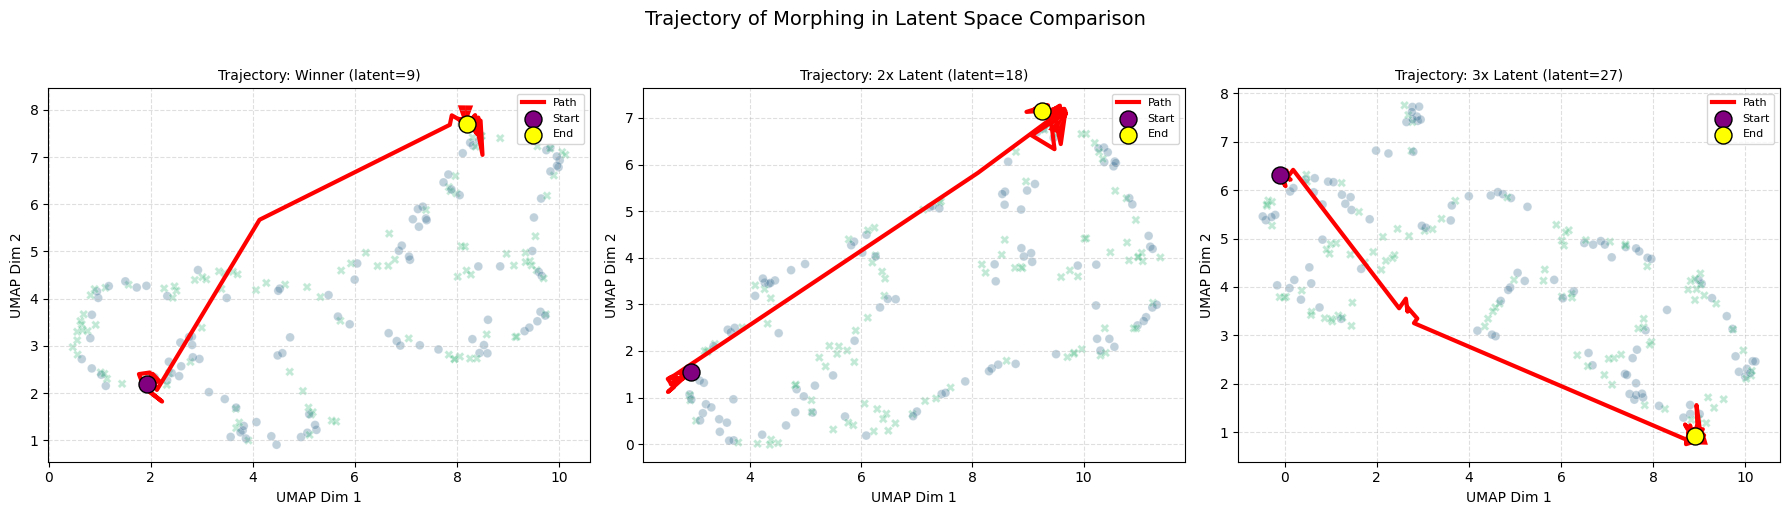

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

steps_traj = 50
alphas_traj = torch.linspace(0, 1, steps_traj)

# Plot Trajectory in UMAP space side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

print("Generating trajectory plots for all 3 models...")

for idx, (item, umap_res, interp) in enumerate(zip(trained_models, umap_results, all_interpolations)):
    model = item['model']
    config = item['config']
    reducer = umap_res['reducer']
    latent_2d = umap_res['latent_2d']
    mu0, mu1 = interp['mu0'], interp['mu1']

    # Generate high-dimensional path
    path_high_dim = []
    model.eval()
    with torch.no_grad():
        for alpha in alphas_traj:
            z_interp = (1 - alpha) * mu0 + alpha * mu1
            path_high_dim.append(z_interp.numpy())

    path_high_dim = np.vstack(path_high_dim)
    path_2d = reducer.transform(path_high_dim)

    # Plot
    ax = axes[idx]
    sns.scatterplot(
        x=latent_2d[:, 0],
        y=latent_2d[:, 1],
        hue=y_test,
        palette='viridis',
        style=y_test,
        s=40,
        alpha=0.3,
        ax=ax,
        legend=False
    )

    # Interpolation path
    ax.plot(path_2d[:, 0], path_2d[:, 1], color='red', linewidth=3, linestyle='-', label='Path')
    ax.scatter(path_2d[0, 0], path_2d[0, 1], c='purple', s=150, edgecolors='black', label='Start', zorder=10)
    ax.scatter(path_2d[-1, 0], path_2d[-1, 1], c='yellow', s=150, edgecolors='black', label='End', zorder=10)

    # Arrow at midpoint
    mid_idx = steps_traj // 2
    ax.arrow(path_2d[mid_idx, 0], path_2d[mid_idx, 1],
             path_2d[mid_idx+1, 0] - path_2d[mid_idx, 0],
             path_2d[mid_idx+1, 1] - path_2d[mid_idx, 1],
             shape='full', lw=0, length_includes_head=True, head_width=0.3, color='red')

    ax.set_title(f"Trajectory: {config['name']}", fontsize=10)
    ax.set_xlabel('UMAP Dim 1')
    ax.set_ylabel('UMAP Dim 2')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.4)

    print(f"  - {config['name']}: Trajectory plot complete")

plt.suptitle('Trajectory of Morphing in Latent Space Comparison', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
This experiment highlighted a cool lesson in Generative AI: the model with the best quantitative metric is not always the one with the best qualitative output.

While the "Winner" model (latent=9) achieved the lowest validation loss and trained the longest, my visual inspection of the generated variations revealed that the middle-ground model (latent=18) actually produced the cleanest, most stable sine waveforms with the least amount of jitter. This discrepancy suggests that the "Winner" may have slightly overfitted to the reconstruction task (minimizing MSE) or focused extra hard on the square wave reconstruction at the expense of the sine waves.

It seems the "Curse of Grad Student Optimization" struck again—blindly following the validation loss could be meaningless. If I were to deploy this, I would likely run the random selection for a little longer or validate in another way to ensure the best balance between metrics and visual quality.

I could also be overthinking the visual aspect and would need to test out different anchors on the "Winner" model.

---